In [1]:
import inference_helpers

import torch
from config import get_config

from sklearn.metrics import mean_squared_error

In [21]:
from importlib import reload
reload(inference_helpers)

<module 'inference_helpers' from 'c:\\Users\\obhlivoj\\DP\\System-Imbalance-Forecasting\\models\\transformer\\inference_helpers.py'>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

import numpy as np

num_models = 1

Using device: cuda


In [3]:
params = ['d_ff', 'Nx', 'n_head', 'dropout', 'lr']

In [13]:
best_metrics, best_models_inds, data_dict = inference_helpers.get_best_model(cfg, './loss/runfinal_', num_models = 1)
loss_validation, loss_cat, preds_gt = inference_helpers.validate_n_models(device, 'final_', params, best_models_inds, eval_data="val")

MODEL EVAL - #1
--------------------


100%|██████████| 14/14 [00:02<00:00,  6.82it/s]


--------------------
Time-step	Error
1		20766.01
2		24655.11
3		26297.71
4		26446.94
5		28175.40
6		28856.84
7		29047.97
8		28960.22


In [14]:
res = inference_helpers.compute_val_errors(preds_gt, num_models = 8)

Step	RMSE	MAPE	MAE	R2
1	144.10	2.84	102.81	0.32
2	157.02	2.74	114.28	0.19
3	162.17	2.70	117.84	0.13
4	162.63	2.60	118.01	0.13
5	167.86	2.66	121.94	0.07
6	169.87	2.71	123.68	0.05
7	170.43	2.68	124.08	0.04
8	170.18	2.70	123.88	0.05


In [15]:
loss_validation, loss_cat, preds_gt = inference_helpers.validate_n_models(device, 'final_', params, best_models_inds, eval_data="test")

MODEL EVAL - #1
--------------------


100%|██████████| 14/14 [00:01<00:00,  7.39it/s]


--------------------
Time-step	Error
1		17986.11
2		21379.49
3		23281.99
4		23828.83
5		25307.93
6		25859.22
7		26153.55
8		26064.07


In [16]:
res = inference_helpers.compute_val_errors(preds_gt, num_models = 8)

Step	RMSE	MAPE	MAE	R2
1	134.11	3.54	93.38	0.34
2	146.22	3.63	103.89	0.21
3	152.58	3.55	108.56	0.14
4	154.37	3.44	109.29	0.12
5	159.08	3.54	112.94	0.07
6	160.81	3.46	114.26	0.05
7	161.72	3.35	115.14	0.03
8	161.44	3.39	114.85	0.04


In [17]:
seq_data = inference_helpers.group_data(preds_gt)

rmse_data = np.empty(len(seq_data), dtype=np.float32)
for ind, dp in enumerate(seq_data):
    rmse_data[ind] = mean_squared_error(dp['true'], dp['pred'], squared=False)

# get k random, best and worst predictions
k = 3
min_loss_inds = np.argsort(rmse_data)[:k].tolist()
max_loss_inds = np.argsort(rmse_data)[-k:].tolist()
rand_inds = np.random.randint(0, len(rmse_data), size=k).tolist()

### Bad predictions

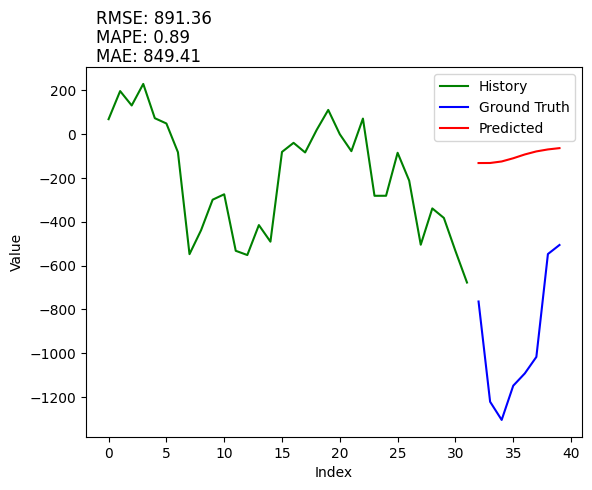

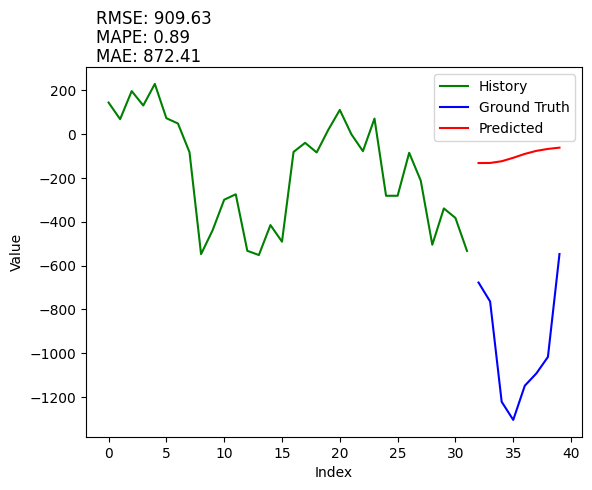

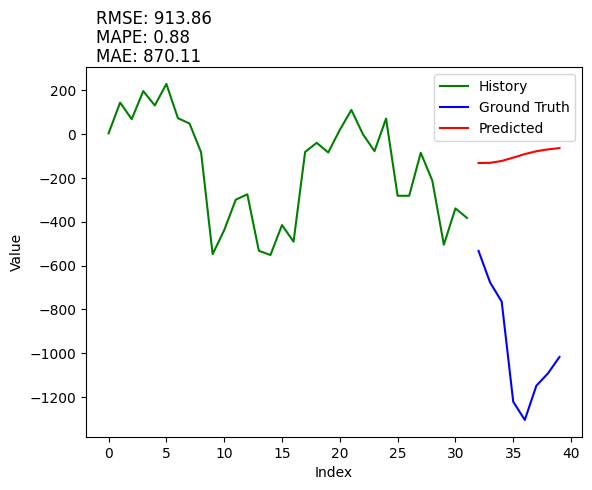

In [22]:
inference_helpers.plot_k_results(seq_data, max_loss_inds)

### Good predictions

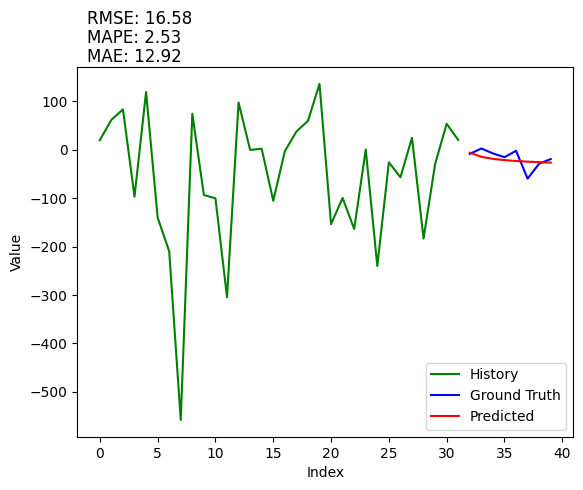

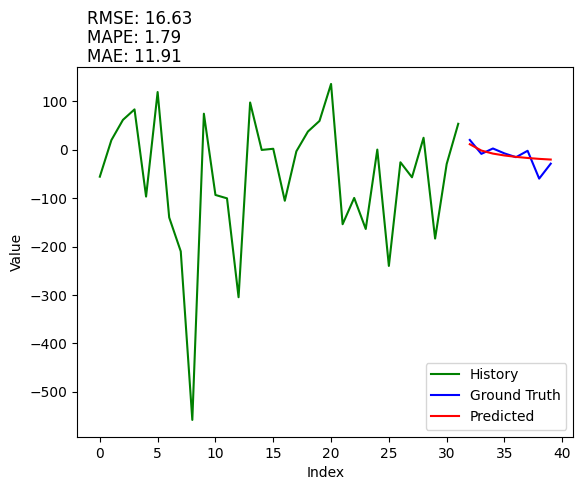

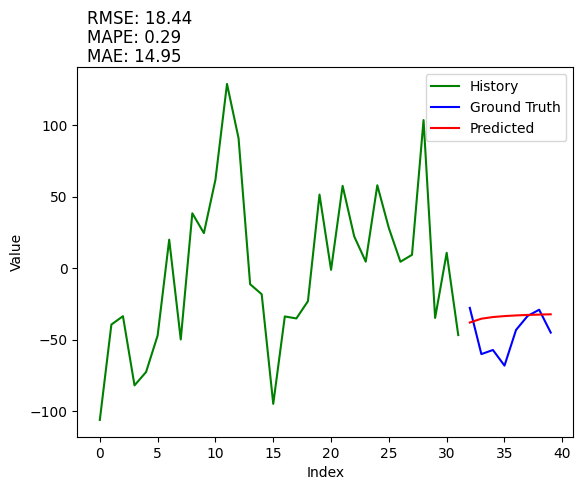

In [23]:
inference_helpers.plot_k_results(seq_data, min_loss_inds)

### Random predictions

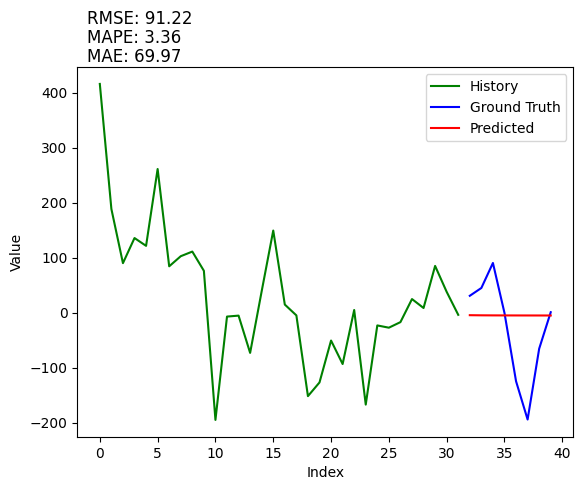

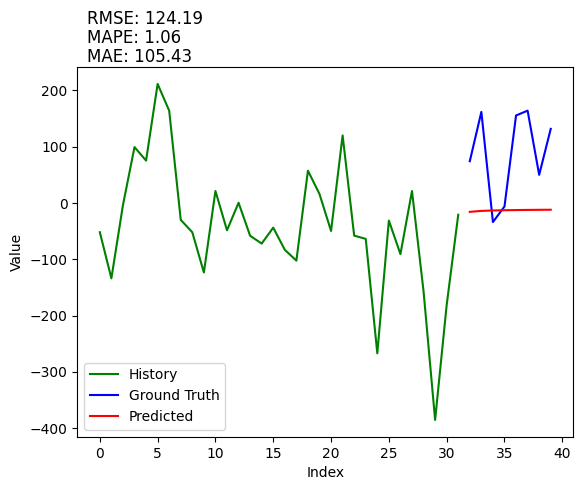

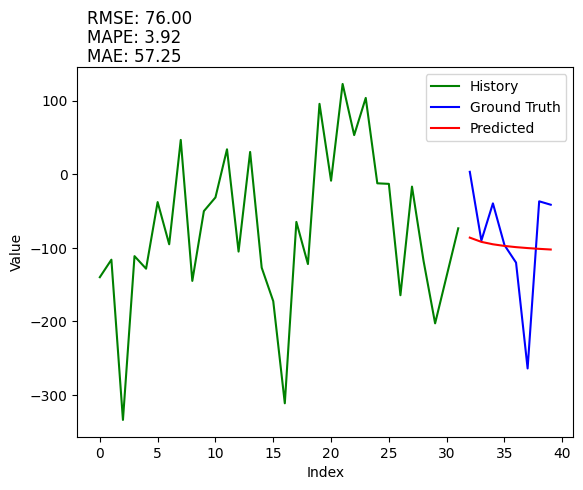

In [24]:
inference_helpers.plot_k_results(seq_data, rand_inds)

In [27]:
rand_inds

[4476, 1242, 7225]

In [30]:
seq_data[7225]['pred']

array([ -85.99619 ,  -91.76853 ,  -95.04949 ,  -97.29079 ,  -98.934845,
       -100.1974  , -101.24801 , -102.16176 ], dtype=float32)

In [31]:
seq_data[7225]['true']

array([   3.455,  -90.05 ,  -39.453,  -96.228, -119.971, -263.84 ,
        -36.626,  -41.268], dtype=float32)

In [41]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(seq_data[7225]['true'][:8], seq_data[7225]['pred'][:8])

3.9206495